In [1]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
License(s): other
100% 1.17G/1.17G [00:13<00:00, 73.2MB/s]
100% 1.17G/1.17G [00:13<00:00, 91.2MB/s]


In [2]:
!unzip labeled-chest-xray-images.zip  -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
 

In [21]:
# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
cudnn.benchmark = True
from torch.optim import lr_scheduler
import torch.nn.functional as F

# Torchvision libraries
from torchvision import datasets, models, transforms
# Other libraries
import matplotlib.pyplot as plt
plt.ion()
from PIL import Image
from tqdm import tqdm
import os
import copy
import random

# Sklearn metrics for evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import numpy as np
from PIL import Image
from tempfile import TemporaryDirectory
import torch.backends.cudnn as cudnn

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data(source_dir, train_dir, val_dir, val_size=0.2):
    if not os.path.exists(source_dir) or len(os.listdir(source_dir)) == 0:
        print(f"المجلد {source_dir} فارغ أو غير موجود.")
        return

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    all_files = [f for f in os.listdir(source_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]

    if len(all_files) == 0:
        print(f"لا توجد صور بصيغة .jpeg أو .jpg أو .png في المجلد: {source_dir}")
        return

    train_files, val_files = train_test_split(all_files, test_size=val_size, random_state=42)

    for f in train_files:
        shutil.move(os.path.join(source_dir, f), os.path.join(train_dir, f))

    for f in val_files:
        shutil.move(os.path.join(source_dir, f), os.path.join(val_dir, f))

split_data("/content/chest_xray/train/NORMAL", "/content/train/NORMAL", "/content/val/NORMAL")
split_data("/content/chest_xray/train/PNEUMONIA", "/content/train/PNEUMONIA", "/content/val/PNEUMONIA")

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

base_dir = "/content"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

train_normal_dir = os.path.join(train_dir, "NORMAL")
train_pneumonia_dir = os.path.join(train_dir, "PNEUMONIA")
val_normal_dir = os.path.join(val_dir, "NORMAL")
val_pneumonia_dir = os.path.join(val_dir, "PNEUMONIA")

train_virus_dir = os.path.join(train_pneumonia_dir, "virus")
train_bacteria_dir = os.path.join(train_pneumonia_dir, "bacteria")
val_virus_dir = os.path.join(val_pneumonia_dir, "virus")
val_bacteria_dir = os.path.join(val_pneumonia_dir, "bacteria")
os.makedirs(train_virus_dir, exist_ok=True)
os.makedirs(train_bacteria_dir, exist_ok=True)
os.makedirs(val_virus_dir, exist_ok=True)
os.makedirs(val_bacteria_dir, exist_ok=True)

In [6]:
for filename in os.listdir(train_pneumonia_dir):
    if "virus" in filename.lower():
        shutil.move(os.path.join(train_pneumonia_dir, filename), train_virus_dir)
    elif "bacteria" in filename.lower():
        shutil.move(os.path.join(train_pneumonia_dir, filename), train_bacteria_dir)


In [7]:
for filename in os.listdir(val_pneumonia_dir):
    if "virus" in filename.lower():
        shutil.move(os.path.join(val_pneumonia_dir, filename), val_virus_dir)
    elif "bacteria" in filename.lower():
        shutil.move(os.path.join(val_pneumonia_dir, filename), val_bacteria_dir)


In [10]:
import os
import pandas as pd
import glob as gb

def count_image_df(path):
    df = pd.DataFrame(columns=["Class", "Count"])

    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)

        if os.path.isdir(folder_path):
            subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

            if subfolders:
                for subfolder in subfolders:
                    subfolder_path = os.path.join(folder_path, subfolder)
                    files = gb.glob(os.path.join(subfolder_path, "*.jpeg"))
                    df.loc[len(df.index)] = [f"{folder}/{subfolder}", len(files)]
            else:
                files = gb.glob(os.path.join(folder_path, "*.jpeg"))
                df.loc[len(df.index)] = [folder, len(files)]

    return df

Images_Path = "/content/train"
count_image = count_image_df(Images_Path)
count_image


,Class,Count
0,PNEUMONIA/bacteria,2033
1,PNEUMONIA/virus,1073
2,NORMAL,1079


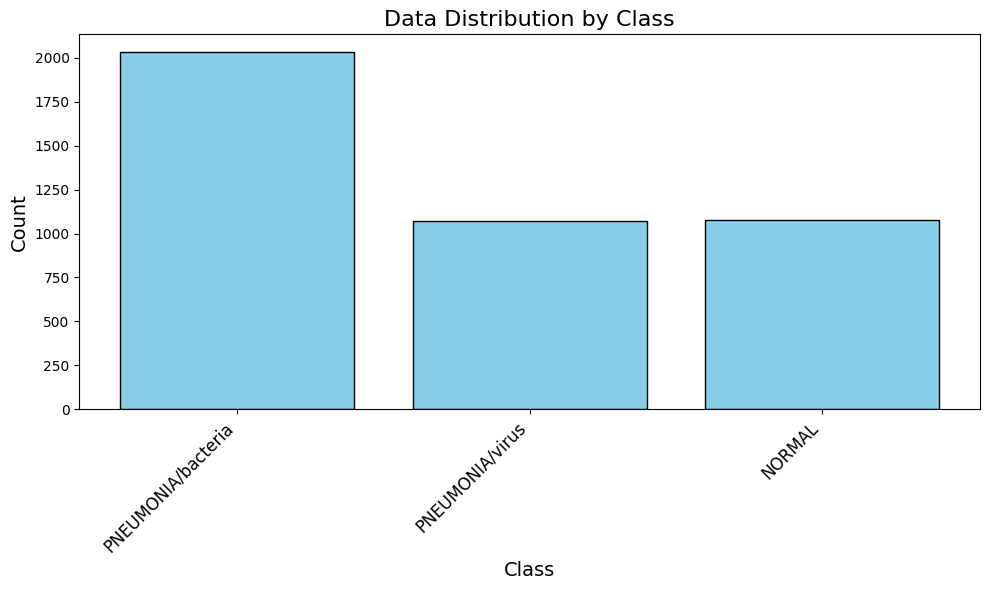

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.bar(count_image["Class"], count_image["Count"], color='skyblue', edgecolor='black')

plt.title("Data Distribution by Class", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.xticks(rotation=45, ha="right", fontsize=12)

plt.tight_layout()

plt.show()


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
import numpy as np

def augment_data(source_dir, augment_count):

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    images = [os.path.join(source_dir, f) for f in os.listdir(source_dir) if f.endswith('.jpeg')]
    images_loaded = [Image.open(img) for img in images]

    count = 0
    for img in images_loaded:
        img_array = np.array(img)

        if img_array.ndim == 2:
            img_array = img_array.reshape((1,) + img_array.shape + (1,))
        else:
            img_array = img_array.reshape((1,) + img_array.shape)

        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=source_dir, save_prefix="aug", save_format="jpeg"):
            count += 1
            if count >= augment_count:
                break
        if count >= augment_count:
            break

base_path = "/content/train"
normal_dir = os.path.join(base_path, "NORMAL")
virus_dir = os.path.join(base_path, "PNEUMONIA/virus")
bacteria_dir = os.path.join(base_path, "PNEUMONIA/bacteria")

target_count = 2538
augment_normal = target_count - len(os.listdir(normal_dir))
augment_virus = target_count - len(os.listdir(virus_dir))

augment_data(normal_dir, augment_normal)
augment_data(virus_dir, augment_virus)
augment_data(bacteria_dir, augment_normal)


In [13]:
import os

def count_images_in_folders(base_path):
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            if folder == "NORMAL":
                image_count = len([f for f in os.listdir(folder_path) if f.endswith('.jpeg')])
                print(f"Class: {folder}, Count: {image_count}")
            elif folder == "PNEUMONIA":
                for subfolder in os.listdir(folder_path):
                    subfolder_path = os.path.join(folder_path, subfolder)
                    if os.path.isdir(subfolder_path):
                        image_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.jpeg')])
                        print(f"Class: PNEUMONIA/{subfolder}, Count: {image_count}")

base_path = "/content/train"
count_images_in_folders(base_path)


Class: PNEUMONIA/bacteria, Count: 3392
Class: PNEUMONIA/virus, Count: 2450
Class: NORMAL, Count: 2430


In [24]:
# Define directories (update these paths if necessary)
train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/chest_xray/test"

In [25]:
# Define transformations for training, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomGrayscale(p=0.1),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [28]:
# Load datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, transform=data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

In [29]:
# Create data loaders with num_workers set to 0 to avoid multiprocessing issues
batch_size = 32
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True, num_workers=0),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0)
}

In [30]:
# Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
class_names

['NORMAL', 'PNEUMONIA bacteria', 'PNEUMONIA virus']

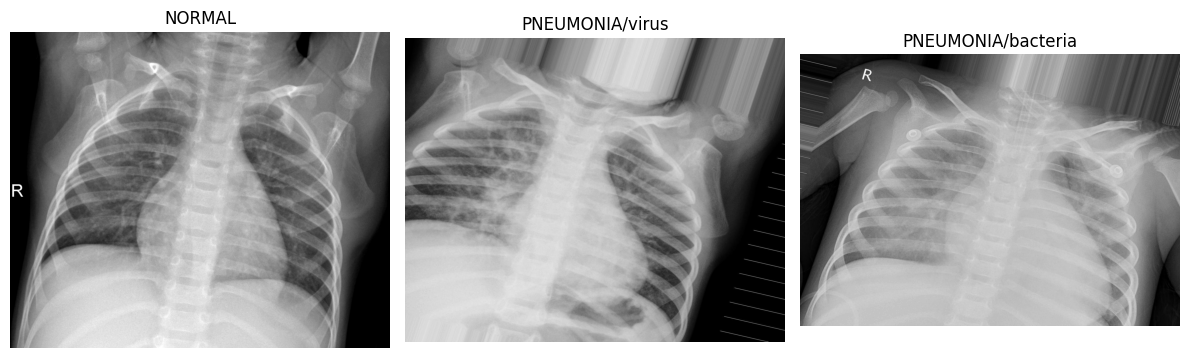

In [31]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def display_sample_images(base_path):
    categories = {
        "NORMAL": os.path.join(base_path, "NORMAL"),
        "PNEUMONIA/virus": os.path.join(base_path, "PNEUMONIA virus"),
        "PNEUMONIA/bacteria": os.path.join(base_path, "PNEUMONIA bacteria")
    }

    plt.figure(figsize=(12, 4))

    for i, (label, path) in enumerate(categories.items(), start=1):
        image_files = [f for f in os.listdir(path) if f.endswith('.jpeg')]
        if image_files:
            image_path = os.path.join(path, image_files[0])
            img = Image.open(image_path)
            plt.subplot(1, len(categories), i)
            plt.imshow(img, cmap='gray')
            plt.title(label)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

base_path = "/content/train"
display_sample_images(base_path)


In [32]:
# Load pre-trained EfficientNet
num_classes=3
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s]


In [33]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [36]:
# optimizer, and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [38]:
num_epochs=15

In [40]:
import torch
from tqdm import tqdm
import os

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, device, save_path):
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    best_val_acc = 0.0  # To keep track of the best validation accuracy

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # Training phase
        model.train()
        train_loss, train_correct, total_train = 0.0, 0, 0
        for inputs, labels in tqdm(dataloaders['train'], desc=f"Training Epoch {epoch+1}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        scheduler.step()
        train_acc = train_correct / total_train
        train_loss = train_loss / total_train
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(dataloaders['val'], desc=f"Validation Epoch {epoch+1}", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_acc = val_correct / total_val
        val_loss = val_loss / total_val
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Print metrics for the epoch
        print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")

        # Save the model if the validation accuracy is the best seen so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"New best validation accuracy: {val_acc:.4f}. Saving model...")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save(model.state_dict(), save_path)

    print("\nTraining complete.")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    return history


In [42]:
save_path = '/content/chest_xray.pth'
history= train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, device,save_path)


Epoch 1/15
----------------------------------------


Training Loss: 0.2742 | Training Accuracy: 0.8835
Validation Loss: 0.5218 | Validation Accuracy: 0.7889
New best validation accuracy: 0.7889. Saving model...

Epoch 2/15
----------------------------------------


Training Loss: 0.2452 | Training Accuracy: 0.8937
Validation Loss: 0.7408 | Validation Accuracy: 0.7297

Epoch 3/15
----------------------------------------


Training Loss: 0.2428 | Training Accuracy: 0.8971
Validation Loss: 0.5178 | Validation Accuracy: 0.7861

Epoch 4/15
----------------------------------------


Training Loss: 0.2224 | Training Accuracy: 0.9012
Validation Loss: 0.4574 | Validation Accuracy: 0.7794

Epoch 5/15
----------------------------------------


Training Loss: 0.2207 | Training Accuracy: 0.9053
Validation Loss: 0.3358 | Validation Accuracy: 0.8281
New best validation accuracy: 0.8281. Saving model...

Epoch 6/15
----------------------------------------


Training Loss: 0.1835 | Training Accuracy: 0.9217
Validation Loss: 0.4305 | Validation Accuracy: 0.7861

Epoch 7/15
----------------------------------------


Training Loss: 0.1699 | Training Accuracy: 0.9242
Validation Loss: 0.5408 | Validation Accuracy: 0.7459

Epoch 8/15
----------------------------------------


Training Loss: 0.1594 | Training Accuracy: 0.9315
Validation Loss: 0.6259 | Validation Accuracy: 0.7163

Epoch 9/15
----------------------------------------


Training Loss: 0.1547 | Training Accuracy: 0.9331
Validation Loss: 0.6781 | Validation Accuracy: 0.6925

Epoch 10/15
----------------------------------------


Training Loss: 0.1430 | Training Accuracy: 0.9391
Validation Loss: 0.6152 | Validation Accuracy: 0.7259

Epoch 11/15
----------------------------------------


Training Loss: 0.1358 | Training Accuracy: 0.9410
Validation Loss: 0.6173 | Validation Accuracy: 0.7268

Epoch 12/15
----------------------------------------


Training Loss: 0.1375 | Training Accuracy: 0.9404
Validation Loss: 0.6362 | Validation Accuracy: 0.7192

Epoch 13/15
----------------------------------------


Training Loss: 0.1325 | Training Accuracy: 0.9449
Validation Loss: 0.6087 | Validation Accuracy: 0.7249

Epoch 14/15
----------------------------------------


Training Loss: 0.1301 | Training Accuracy: 0.9446
Validation Loss: 0.6145 | Validation Accuracy: 0.7249

Epoch 15/15
----------------------------------------


Training Loss: 0.1281 | Training Accuracy: 0.9462
Validation Loss: 0.6269 | Validation Accuracy: 0.7278

Training complete.
Best Validation Accuracy: 0.8281


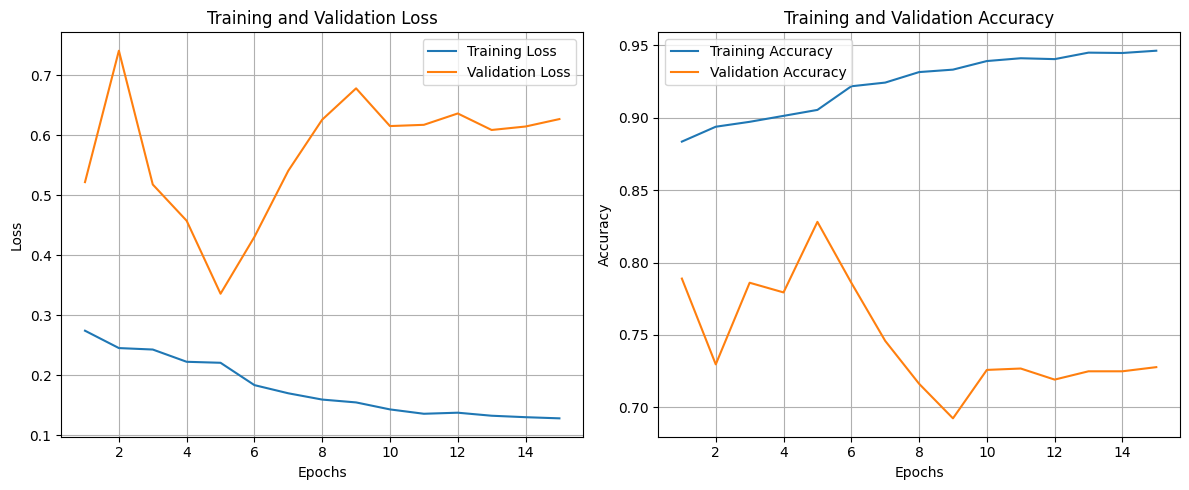

In [43]:
import matplotlib.pyplot as plt

# Plotting function
def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Training Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()



# Plot the training history
plot_training_history(history)


In [44]:
def test(model, dataloader, device, class_names):
    # Import accuracy_score and other metrics here
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Return metrics
    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }
    return metrics

In [48]:
# Test the model
test_dataloader = dataloaders['train']
metrics = test(model, test_dataloader, device, class_names)

# Print overall metrics
print("\nTest Metrics:")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")


Testing: 100%|██████████| 259/259 [03:41<00:00,  1.17it/s]


Classification Report:
                    precision    recall  f1-score   support

            NORMAL       1.00      1.00      1.00      2430
PNEUMONIA bacteria       0.94      0.94      0.94      3392
   PNEUMONIA virus       0.92      0.92      0.92      2450

          accuracy                           0.95      8272
         macro avg       0.95      0.95      0.95      8272
      weighted avg       0.95      0.95      0.95      8272


Test Metrics:
Accuracy: 0.9512
Precision: 0.9521
Recall: 0.9526
F1_score: 0.9524


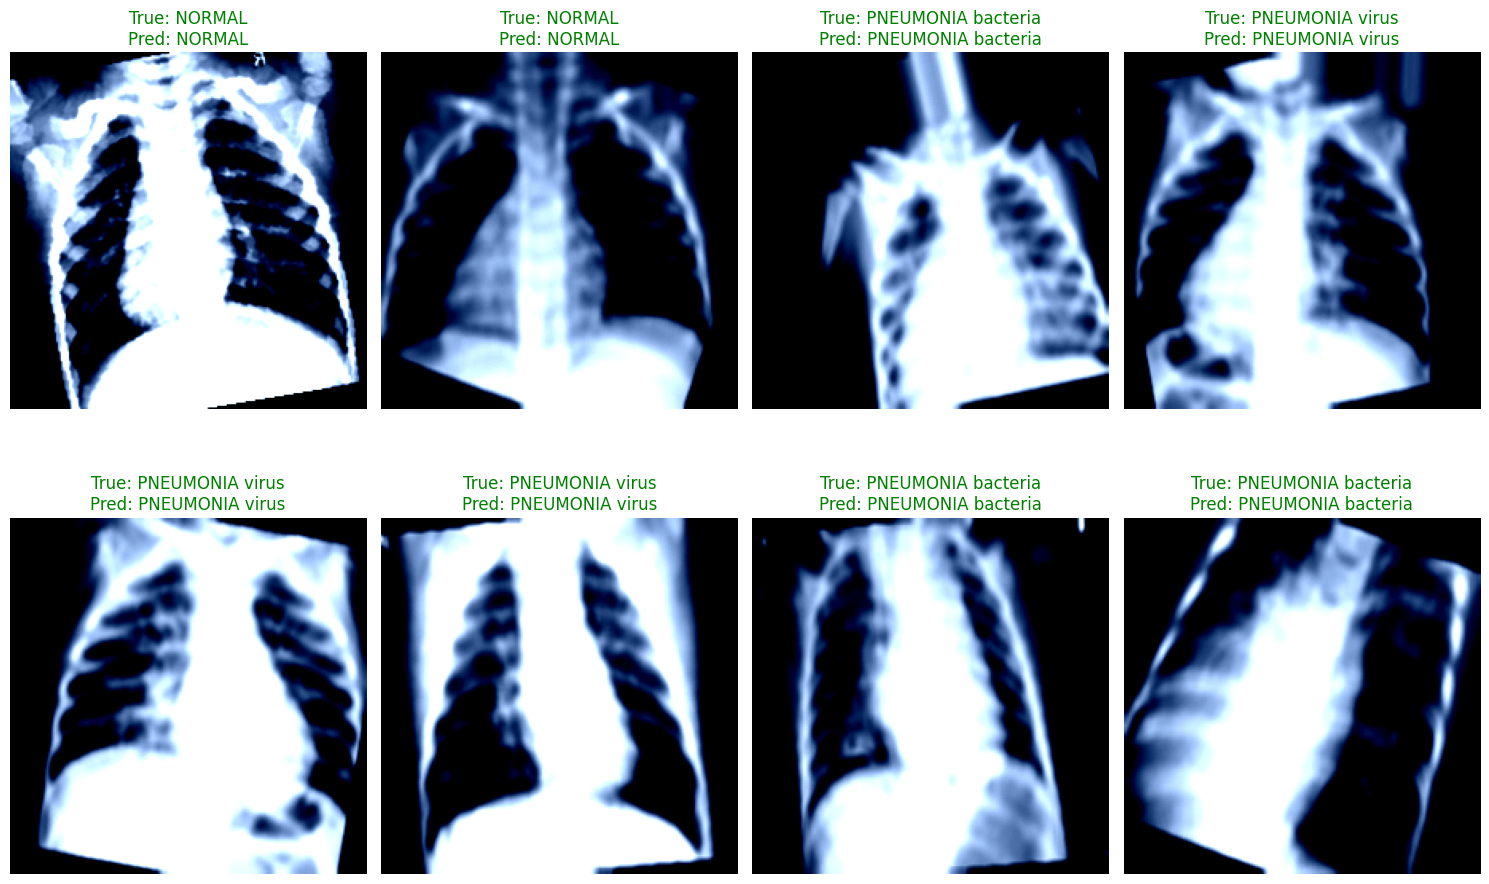

In [49]:

def visualize_predictions(model, dataloader, class_names, device, num_images=8):

    model.eval()
    images_shown = 0

    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    break

                # Convert image tensor to numpy array
                img = inputs[i].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img * 255, 0, 255).astype(np.uint8)

                ax = plt.subplot(int(num_images / 4), 4, images_shown + 1)
                ax.imshow(img)
                ax.axis("off")
                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]
                ax.set_title(f"True: {true_label}\nPred: {pred_label}", color="green" if true_label == pred_label else "red")

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()
visualize_predictions(model, test_dataloader, class_names, device, num_images=8)